# Module 2: Seasonal Crop Water Requirement (CWR), Green ETa and Blue ETa

**Last update: 23-Sept-2024**

[![](https://raw.githubusercontent.com//wateraccounting/WaPORMOOC/main/images/colab-badge.png)](https://colab.research.google.com/github/wateraccounting/WaPORIPA/blob/main/Notebooks_beta/Module_2_Seasonal_CWR_GreenBlueETa.ipynb?target=\"_blank\")

### Introduction

This Notebook helps to calculate seasonal crop water requirements (ETc), green and blue actual water consumption (Seasonal Green ETa and Season Blue ETa).

### Workflow:

We will follow these steps to complete the calculations:

0. **Import Python Libraries**
1. **Upload data**
2. **Resample PCP&RET raster layers**: align the spatial resolution and extent of RET&PCP with Seasonal AETI
3. **Import Data for Temporal Aggregation**: Import resampled dekadal RET & PCP, seasonal AETI, crop coefficient (kc), and define crop growing periods.
4. **Defines (and create) the output folder**
5. **Define Function for Temporal Aggregation**
6. **Calculate Seasonal RET and CWR (ETc)**
7. **Calculate Seasonal Effective Precipitation (Peff)**
8. **Calculate Seasonal Green ETa and Blue ETa**
9. **Zip and download the output**

### Data Used:

1. **Data Types**: RET&PCP, Seasonal AETI (outputs of Module_1a or Module_1b), and kc (excel format)
2. **Temporal Resolution**: Dekadal (PCP, RET) and Seasonal (AETI)
3. **Season Start Date**: SOS (Start of a season)
4. **Season End Date**:  EOS (End of a season)

The function `SumSeason` used in this Notebook is adapted from the [WaPORWP repository](https://github.com/wateraccounting/WAPORWP).

© 2020 Abebe Chukalla. Licensed under **CC BY 4.0 Creative Commons**.

© 2024 IHE Delft. Licensed under **CC BY-SA Creative Commons**.


---

## **0. Import Python modules/libraries**

In [1]:
!pip install rioxarray --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 31.9 MB/s eta 0:00:00


In [2]:
!pip install gdal

In [3]:
import os                                 # Module for interacting with the operating system (e.g., file and directory handling)
import sys                                # Provides access to system-specific parameters and functions (e.g., command line arguments, environment)
import glob                               # Used to retrieve files/pathnames matching a specified pattern (e.g., *.tif for all TIFF files)
import re                                 # Regular expressions module used for searching, matching, and replacing strings (e.g., re.sub() for replacing substrings)

import rioxarray as rio                   # An extension of xarray that supports geospatial raster data handling (e.g., reading/writing GeoTIFFs)
import rasterio                           # Library for reading, writing, and analyzing geospatial raster data (e.g., handling .tif files)
from rasterio.warp import reproject, Resampling  # Functions for reprojection and resampling raster data to match spatial properties (e.g., CRS, resolution)

import pandas as pd                       # Data analysis and manipulation library for working with structured data (e.g., DataFrames)
import numpy as np                        # Stands for 'Numerical Python', used for scientific computing with arrays (e.g., matrix operations, statistical functions)
import calendar                           # Module for working with calendar-related functions (e.g., generating dates, checking leap years)
import datetime                           # Module for handling date and time operations (e.g., converting strings to dates, date arithmetic)
from osgeo import gdal                    # GDAL (Geospatial Data Abstraction Library) used for reading and writing raster and vector geospatial data formats
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt      # A library for creating static, animated, and interactive visualizations in Python (e.g., plotting 2D graphs, images)
import matplotlib.pyplot as plt

## **1. Upload data**

Upload/mount the data:
- The dekadal raster data (PCP, RET) and the seasonal AETI
- The kc, Crop coefficient, a dimensionless factor that adjusts the reference evapotranspiration (RET) to account for the crop type, growth stage, and local environmental factors.

### Upload the ZIP file containing PCP & RET data

In [4]:
# Upload Zip file (PCP and RET data to be resampled)
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [ ]:
# From google drive
from google.colab import drive
drive.mount('/content/drive')

In [5]:
!unzip '/content/data.zip' -d '/content'


Archive:  /content/data.zip
   creating: /content/content/output/
   creating: /content/content/output/L1-RET-D/
  inflating: /content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-04-01.tif  
  inflating: /content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-05-01.tif  
  inflating: /content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-04-21.tif  
  inflating: /content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-04-11.tif  
  inflating: /content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-03-11.tif  
  inflating: /content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-05-21.tif  
  inflating: /content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-03-01.tif  
  inflating: /content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-03-21.tif  
  inflating: /content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-05-11.tif  
   creating: /content/c

###  Upload the zip file of the seasonal actual evapotranpiration files

In [6]:
# upload seasonal actual evapotranpiration files.
from google.colab import files
uploaded = files.upload()

Saving pywapor_out.zip to pywapor_out.zip


In [ ]:
# From google drive
from google.colab import drive
drive.mount('/content/drive')

In [7]:
!unzip '/content/pywapor_out.zip' -d '/content'          # Uncheck this for Module_1b output based on pywapor data
# !unzip '/content/WaPORv3_seasonal' -d '/content'       # Uncheck this for Module_1a output based on pywapor data

Archive:  /content/pywapor_out.zip
   creating: /content/content/output/seasonal/
   creating: /content/content/output/seasonal/pywapor_AETI_S/
  inflating: /content/content/output/seasonal/pywapor_AETI_S/pywapor_AETI_S_2022-03-01_2023-05-31.tif  
   creating: /content/content/output/seasonal/pywapor_I_S/
  inflating: /content/content/output/seasonal/pywapor_I_S/pywapor_I_S_2022-03-01_2023-05-31.tif  
   creating: /content/content/output/seasonal/pywapor_NPP_S/
  inflating: /content/content/output/seasonal/pywapor_NPP_S/pywapor_NPP_S_2022-03-01_2023-05-31.tif  
   creating: /content/content/output/seasonal/pywapor_RSM_S/
  inflating: /content/content/output/seasonal/pywapor_RSM_S/pywapor_RSM_S_2022-03-01_2023-05-31.tif  
   creating: /content/content/output/seasonal/pywapor_T_S/
  inflating: /content/content/output/seasonal/pywapor_T_S/pywapor_T_S_2022-03-01_2023-05-31.tif  
   creating: /content/content/output/seasonal/pywapor_E_S/
  inflating: /content/content/output/seasonal/pywapor

###  Locate the directory and data to be resampled (PCP & RET) and used as a reference (Seasonal AETI)

In [8]:
# Paths to the files
dir_proj     = os.path.split(os.getcwd())[0]
dir_data     = "/content/content/output/"

input_folderPCP = os.path.join(dir_proj, dir_data, "L1-PCP-D")
input_folderRET = os.path.join(dir_proj, dir_data, "L1-RET-D")

et_files        = os.path.join(dir_proj, dir_data, "seasonal/pywapor_AETI_S")
et_file         = sorted(glob.glob(et_files  + '/*.tif'))[0]

input_folderPCP, input_folderRET, et_file

('/content/content/output/L1-PCP-D',
 '/content/content/output/L1-RET-D',
 '/content/content/output/seasonal/pywapor_AETI_S/pywapor_AETI_S_2022-03-01_2023-05-31.tif')

## **2. Resample PCP & RET raster layers**

## i. Define function for resampling

In [9]:
# Function for resampling

def resample_raster_files(input_folder, reference_file, output_folder):
    """
    Resamples all raster files in the input folder to match the spatial resolution and CRS
    of the reference raster file and saves the resampled files in the output folder.

    Parameters:
    input_folder (str): Path to the folder containing the raster files to be resampled.
    reference_file (str): Path to the reference raster file used for resampling.
    output_folder (str): Path to the folder where the resampled files will be saved.
    """

    # Get all raster files to be resampled
    input_files = glob.glob(os.path.join(input_folder, "*.tif"))

    # Open the reference file to get its profile
    with rasterio.open(reference_file) as ref_src:
        ref_profile = ref_src.profile

        # Loop through each raster file to be resampled
        for input_file in input_files:
            with rasterio.open(input_file) as src:
                src_data = src.read(1)

                # Create an empty array to store the resampled data
                resampled_data = np.empty((ref_profile['height'], ref_profile['width']), dtype=src_data.dtype)

                # Resample the data
                reproject(
                    source=src_data,
                    destination=resampled_data,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref_profile['transform'],
                    dst_crs=ref_profile['crs'],
                    resampling=Resampling.nearest
                )

                # Update profile metadata using the reference file's profile
                output_profile = src.profile.copy()
                output_profile.update(
                    transform=ref_profile['transform'],
                    height=ref_profile['height'],
                    width=ref_profile['width'],
                    crs=ref_profile['crs']
                )

                # Preserve band-specific metadata
                band1_meta = src.tags(1)

                # Save resampled file with the updated profile and original metadata
                output_file = os.path.join(output_folder, os.path.basename(input_file))
                with rasterio.open(output_file, 'w', **output_profile) as dst:
                    dst.write(resampled_data, 1)
                    dst.update_tags(1, **band1_meta)  # Preserve band metadata

    print("Resampling completed.")

## ii. Resample PCP ddata

In [10]:
# Paths to the files
dir_proj     = os.path.split(os.getcwd())[0]
dir_data     = "/content/content/output/"

# Resample pricipitation
input_folder   = input_folderPCP
reference_file = et_file
output_folder  = os.path.join(dir_proj, dir_data, "PCP_resampled")  #  the directory of the output folder

# Make one if the folder does not exit
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

resample_raster_files (input_folder, reference_file, output_folder)

Resampling completed.


## iii. Resample RET ddata

In [11]:
# Paths to the files
dir_proj     = os.path.split(os.getcwd())[0]
dir_data     = "/content/content/output/"

# Resample reference evapotranspiration
input_folder   = input_folderRET
reference_file = et_file
output_folder  = os.path.join(dir_proj, dir_data, "RET_resampled")  #  the directory of the output folder

# Make one if the folder does not exit
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

resample_raster_files (input_folder, reference_file, output_folder)

Resampling completed.


## **3. Import data for temporal aggregation**

## Step I. Import raster (WaPOR) data

In this section you will be importing the WaPOR data.

In [12]:
# import resampled PCP and RET, and Seasonal AETI
dir_proj     = os.path.split(os.getcwd())[0]                                     # Specify the data directory
dir_data     = "/content/content/output/"

input_folderPCP = os.path.join(dir_proj, dir_data, "PCP_resampled")
input_fhsPCP    = sorted(glob.glob(input_folderPCP + '/*.tif'))

input_folderRET = os.path.join(dir_proj, dir_data, "RET_resampled")
input_fhsRET    = sorted(glob.glob(input_folderRET + '/*.tif'))

input_folderETas = os.path.join(dir_proj, dir_data, "seasonal/pywapor_AETI_S")   # Define the input folder path for seasonal AETI data
input_fhsETas    = sorted(glob.glob(input_folderETas+ '/*.tif'))           # Use glob to find all .tif files in the specified folder

input_fhsPCP , input_fhsRET, input_fhsETas

(['/content/content/output/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-03-01.tif',
  '/content/content/output/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-03-11.tif',
  '/content/content/output/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-03-21.tif',
  '/content/content/output/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-04-01.tif',
  '/content/content/output/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-04-11.tif',
  '/content/content/output/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-04-21.tif',
  '/content/content/output/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-05-01.tif',
  '/content/content/output/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-05-11.tif',
  '/content/content/output/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-05-21.tif'],
 ['/content/content/output/RET_resampled/bb_L1-RET-D_NONE_dekad_converted_2023-03-01.tif',
  '/content/content/output/RET_resampled/bb_L1-RET-D_NONE_dekad_converted_2023-03-11.tif'

## Step II. Import crop-specific information, define the season and crop coefficient (kc)

## Define seasons

Here the start (SOS) and end (EOS) dates for each season are defined.

In [13]:
season_periods = {
    'season1': {'SOS': '2023-03-01', 'EOS': '2023-05-31'}
}

## Import crop coefficient factor

In [14]:
# upload crop coefficient (kc) from Excel file (df_Kc.xlsx)
from google.colab import files
uploaded = files.upload()

Saving df_Kc.xlsx to df_Kc.xlsx


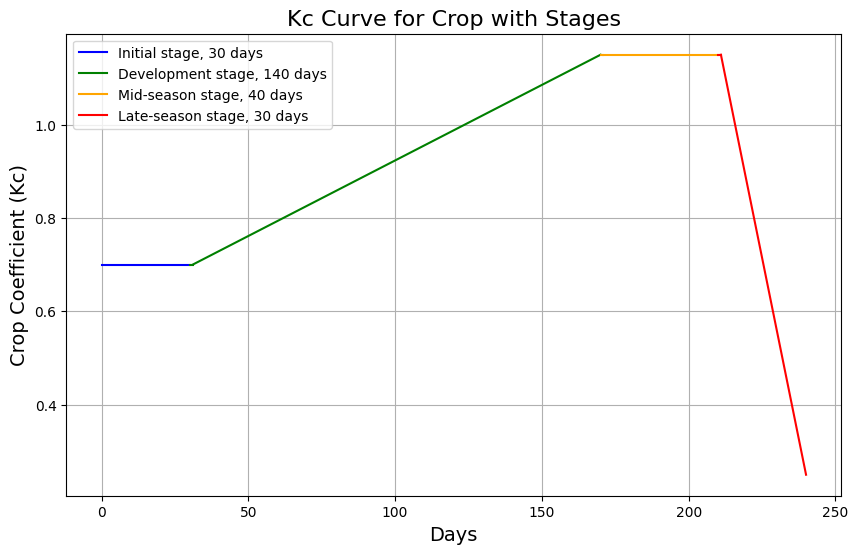

,Stages,Days,kc,Unnamed: 3,Crop stages,Duration_days,Kc,Stage_Label,Stage_Legend
0,Initial_s,0,0.70,NaN,Initial,30.0,0.70,Initial,"Initial stage, 30 days"
1,Initial_e,30,0.70,NaN,NaN,NaN,NaN,Initial,"Initial stage, 30 days"
2,development_s,31,0.70,NaN,Development,140.0,NaN,Development,"Development stage, 140 days"
3,development_e,170,1.15,NaN,NaN,NaN,1.15,Development,"Development stage, 140 days"
4,mid-season_s,171,1.15,NaN,Mid-season,40.0,NaN,Mid-season,"Mid-season stage, 40 days"
5,mid-season_e,210,1.15,NaN,NaN,NaN,NaN,Mid-season,"Mid-season stage, 40 days"
6,late-season_s,211,1.15,NaN,Late-season,30.0,NaN,Late-season,"Late-season stage, 30 days"
7,late-season_e,240,0.25,NaN,NaN,NaN,0.25,Late-season,"Late-season stage, 30 days"


In [15]:
# Plot Kc values
# Step 1: Read the Kc data from an Excel file
dir_proj = os.path.split(os.getcwd())[0]  # Get the project directory
dir_data = "/content/"  # Set the data directory
df_kc = pd.read_excel(os.path.join(dir_proj, dir_data, 'df_Kc.xlsx'))  # Load crop data

# Step 2: Map and create stage labels with duration in days
df_kc['Stage_Label'] = df_kc['Stages'].replace({
    'Initial_s': 'Initial', 'Initial_e': 'Initial',
    'development_s': 'Development', 'development_e': 'Development',
    'mid-season_s': 'Mid-season', 'mid-season_e': 'Mid-season',
    'late-season_s': 'Late-season', 'late-season_e': 'Late-season'
})

# Create stage legend combining stage name and duration (first occurrence for each stage)
df_kc['Stage_Legend'] = df_kc.groupby('Stage_Label')['Duration_days'].transform('first')
df_kc['Stage_Legend'] = df_kc.apply(lambda row: f"{row['Stage_Label']} stage, {int(row['Stage_Legend'])} days"
                                    if pd.notna(row['Stage_Legend']) else f"{row['Stage_Label']} stage", axis=1)

# Step 3: Plotting with colors and labels
colors = {'Initial': 'blue', 'Development': 'green', 'Mid-season': 'orange', 'Late-season': 'red'}
plt.figure(figsize=(10, 6))

for i in range(1, len(df_kc['Days'])):
    plt.plot(df_kc['Days'][i-1:i+1], df_kc['kc'][i-1:i+1], color=colors[df_kc['Stage_Label'][i]], label=df_kc['Stage_Legend'][i])

# Remove duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))  # Keep unique labels and handles
plt.legend(unique.values(), unique.keys(), loc='best')

# Add labels, title, and grid
plt.xlabel('Days', fontsize=14)
plt.ylabel('Crop Coefficient (Kc)', fontsize=14)
plt.title('Kc Curve for Crop with Stages', fontsize=16)
plt.grid(True)
plt.show()

df_kc

## **4. Defines (and create) the output folder**

In [16]:
# Define the project directory and output folder path
dir_proj = os.path.split(os.getcwd())[0]  # Get the parent directory of the current working directory
dir_data = r"/content/output/"            # Specify the directory where the output will be stored

output_folderRET         = os.path.join(dir_proj, dir_data, "RET_season")
output_folderETc         = os.path.join(dir_proj, dir_data, "ETc_season")
output_folderETpmon      = os.path.join(dir_proj, dir_data, "2L3_ETc_month")
output_folderPCP         = os.path.join(dir_proj, dir_data, "PCP_season")
output_folderPCPmon      = os.path.join(dir_proj, dir_data, "PCP_month")
output_folderPCPeff      = os.path.join(dir_proj, dir_data,    "PCPeff_season")
output_folderPCPeffmon      = os.path.join(dir_proj, dir_data, "PCPeff_month")
output_folderGreenBlueET = os.path.join(dir_proj, dir_data,    "GreenBlueET_season")

# Make one if the folder does not exit
if not os.path.exists(output_folderRET):
    os.makedirs(output_folderRET)

if not os.path.exists(output_folderETc):
    os.makedirs(output_folderETc)

if not os.path.exists(output_folderPCP):
    os.makedirs(output_folderPCP)
if not os.path.exists(output_folderPCPeff):
    os.makedirs(output_folderPCPeff)

if not os.path.exists(output_folderGreenBlueET):
    os.makedirs(output_folderGreenBlueET)

if not os.path.exists(output_folderETpmon):
    os.makedirs(output_folderETpmon)
if not os.path.exists(output_folderPCPmon):
    os.makedirs(output_folderPCPmon)
if not os.path.exists(output_folderPCPeffmon):
    os.makedirs(output_folderPCPeffmon)

## **5. Define function for temporal aggregation**

This script defines the SumSeason function, which will be used in the following sections to aggregate seasonal data.

© 2020 Abebe Chukalla. Licensed under CC BY 4.0 Creative Commons.

In [17]:
# Function to sum raster values between two specified dates (sowing and harvesting)
def SumSeason(input_fhs, sowing_date, harvesting_date):
    """
    This function sums the raster data that fall within the provided sowing and harvesting dates.

    Parameters:
    - input_fhs: List of file paths to the input raster files
    - sowing_date: The starting date of the season (as a datetime.date object)
    - harvesting_date: The ending date of the season (as a datetime.date object)

    Returns:
    - Sums: Aggregated raster data for the specified period
    """

    # Initialize the cumulative sum variable for raster data
    Sums = 0

    # Loop through each raster file
    for i, in_fh in enumerate(input_fhs):
        # Open the raster file and mask out invalid data using the fill value from the attributes
        ds = rio.open_rasterio(in_fh)
        ds = ds.where(ds != ds.attrs['_FillValue'])  # Ignore fill values in the raster data

        # Save the attributes of the first raster for later use (metadata such as start/end dates)
        if i == 0:
            attrs = ds.attrs

        # Extract the start and end dates of the raster from its attributes
        raster_startdate = datetime.datetime.strptime(ds.attrs['start_date'], '%Y-%m-%d').date()
        raster_enddate = datetime.datetime.strptime(ds.attrs['end_date'], '%Y-%m-%d').date()

        # Case 1: The entire raster period is within the sowing and harvesting dates
        if (raster_startdate >= sowing_date) and (raster_enddate <= harvesting_date):
            Sum = ds  # Use the full raster data
            Sums += Sum  # Accumulate it into the total sum

        # Case 2: Raster starts before sowing but ends within the growing season
        elif (raster_startdate < sowing_date) and (raster_enddate > sowing_date) and (raster_enddate < harvesting_date):
            # Add the fraction of the raster data that overlaps with the sowing date
            Sum = ds * ((raster_enddate - sowing_date) / (raster_enddate - raster_startdate))
            Sums += Sum  # Accumulate the fractional sum

        # Case 3: Raster starts within the growing season but ends after the harvesting date
        elif (raster_startdate > sowing_date) and (raster_startdate < harvesting_date) and (raster_enddate > harvesting_date):
            # Add the fraction of the raster data that overlaps with the harvesting date
            Sum = ds * ((harvesting_date - raster_startdate) / (raster_enddate - raster_startdate))
            Sums += Sum  # Accumulate the fractional sum

        # Case 4: Sowing and harvesting dates are both within the raster period
        elif (sowing_date >= raster_startdate) and (harvesting_date <= raster_enddate):
            # Add the fraction of the raster data that overlaps with both the sowing and harvesting dates
            Sum = ds * ((harvesting_date - sowing_date) / (raster_enddate - raster_startdate))
            Sums += Sum  # Accumulate the fractional sum

    # Update the raster attributes with new seasonal start and end dates
    attrs.update({
        'start_date': datetime.datetime.strftime(SOS, '%Y-%m-%d'),  # Seasonal start date
        'end_date': datetime.datetime.strftime(EOS, '%Y-%m-%d'),    # Seasonal end date
        'units': 'mm/season'  # Update units to reflect seasonal aggregation
    })

    # Remove unnecessary attributes to clean up the metadata
    del attrs['number_of_days']
    del attrs['temporal_resolution']
    del attrs['units_conversion_factor']

    # Assign the updated attributes to the summed raster
    Sums.attrs = attrs

    # Return the final aggregated raster data
    return Sums


## **6. Calculate seasonal Reference Evapotranspiration(RET), and CWR ( ETc = Kc*RET)**

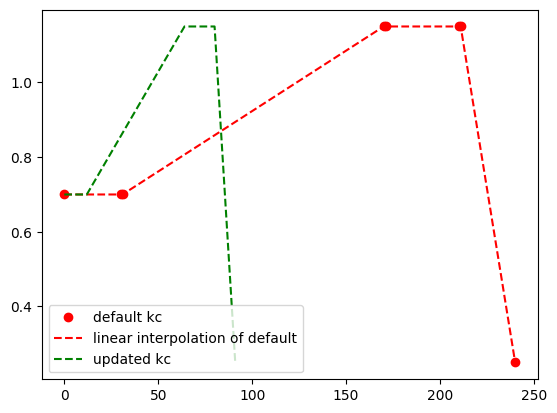

The mean & SD monthly ETc [mm] in 2023-03-01/2023-03-31 is 123.3 & 2.6
The mean & SD monthly RET [mm] in 2023-03-01/2023-03-31 is 158.4 & 3.4
The mean & SD monthly ETc [mm] in 2023-04-01/2023-04-30 is 198.7 & 2.9
The mean & SD monthly RET [mm] in 2023-04-01/2023-04-30 is 200.7 & 2.9
The mean & SD monthly ETc [mm] in 2023-05-01/2023-05-31 is 188.0 & 2.6
The mean & SD monthly RET [mm] in 2023-05-01/2023-05-31 is 273.7 & 3.7
The mean & SD seasonal RET [mm] in 2023-03-01/2023-05-31 is 632.9 & 10.0
The mean & SD seasonal ETc [mm] in 2023-03-01/2023-05-31 is 510.0 & 8.1


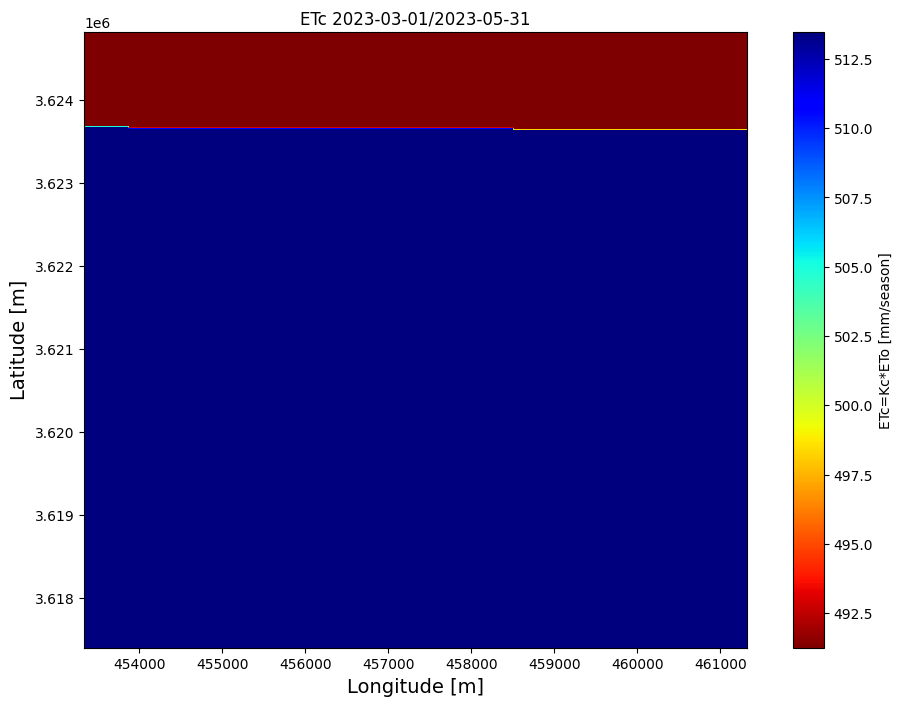

In [18]:
# Summary:
# This script calculates the seasonal reference evapotranspiration (RET) and the potential crop water requirement
# (ETc = Kc * RET) for each season. It adjusts the crop coefficient (Kc) curve based on the cropping period,
# calculates the monthly and seasonal RET and ETp values, and outputs the results in raster format.
# The script also visualizes the adjusted Kc curve and the resulting ETc map.

# Iterate over each season in the season_periods dictionary
for season, dates in season_periods.items():
    SOS = datetime.datetime.strptime(dates['SOS'], '%Y-%m-%d').date()  # Start date of the season (SOS)
    EOS = datetime.datetime.strptime(dates['EOS'], '%Y-%m-%d').date()  # End date of the season (EOS)

    # Adjust the crop coefficient (Kc) curve to match the specific cropping period
    defaultCropPeriod = df_kc.Days[df_kc.Stages == 'late-season_e']  # Default crop period length
    cropperiod = EOS - SOS  # Actual cropping period length for the season
    periodcorrection = cropperiod.days / defaultCropPeriod  # Correction factor
    df_kc['Days_corr'] = df_kc.apply(lambda row: (row['Days'] * periodcorrection).round(0), axis=1)  # Adjust days
    df_kc['Date'] = df_kc.apply(lambda row: SOS + datetime.timedelta(days=row['Days_corr']), axis=1)  # Add corrected dates

    # Interpolate Kc values over the corrected crop period
    xcorr = df_kc['Days_corr']
    y = df_kc['kc']
    fkcnew = interp1d(xcorr, y, kind='linear')

    # Plot Kc curves (default and adjusted) for the first season only
    if season == 'season1':
        x = df_kc['Days']
        fkcdefault = interp1d(x, y, kind='linear')
        plt.plot(x, y, 'ro', x, fkcdefault(x), 'r--', xcorr, fkcnew(xcorr), 'g--')
        plt.legend(['default kc', 'linear interpolation of default', 'updated kc'], loc='best')
        plt.show()

    # Initialize cumulative seasonal RET (ETo) and ETc
    seasonETo = 0
    seasonETc = 0
    date_s = SOS

    # Loop through each month in the season to calculate monthly RET and ETc
    while date_s < EOS:
        # Helper functions to get the first and last day of the month
        def first_day_of_month(date):
            return date.replace(day=1)

        def last_day_of_month(date):
            return date.replace(day=31) if date.month == 12 else date.replace(month=date.month + 1, day=1) - datetime.timedelta(days=1)

        startdate = max(first_day_of_month(date_s), SOS)
        enddate = min(last_day_of_month(date_s), EOS)

        # Interpolate Kc for the start and end of the month, then compute the average Kc
        kc_s = fkcnew((startdate - SOS).days)
        kc_f = fkcnew((enddate - SOS).days)
        kc_m = (kc_s + kc_f) / 2

        # Calculate monthly ETo and ETp
        ET0m = SumSeason(input_fhsRET, startdate, enddate)  # Sum of reference evapotranspiration (RET) for the month
        ETc  = kc_m * ET0m                                  # Monthly potential crop water requirement (ETc = Kc * RET)

        # Move to the next month
        date_s = enddate + datetime.timedelta(days=1)

        # Accumulate monthly RET and ETp for the season
        seasonETo += ET0m
        seasonETc += ETc

        # Save the monthly ETp as a raster file
        out_fh = os.path.join(output_folderETpmon, f'ETcmon_{startdate}_to_{enddate}.tif')
        seasonETc.rio.to_raster(out_fh)

        # Print the monthly statistics for RET and ETc
        print(f'The mean & SD monthly ETc [mm] in {startdate}/{enddate} is {np.nanmean(ETc).round(1)} & {np.nanstd(ETc).round(1)}')
        print(f'The mean & SD monthly RET [mm] in {startdate}/{enddate} is {np.nanmean(ET0m).round(1)} & {np.nanstd(ET0m).round(1)}')

    # Save the seasonal RET and ETp as raster files
    out_fh = os.path.join(output_folderRET, f'RET_{season}_{dates["SOS"]}_to_{dates["EOS"]}.tif')
    seasonETo.rio.to_raster(out_fh)
    print(f'The mean & SD seasonal RET [mm] in {SOS}/{EOS} is {np.nanmean(seasonETo).round(1)} & {np.nanstd(seasonETo).round(1)}')

    out_fh = os.path.join(output_folderETc, f'ETc_{season}_{dates["SOS"]}_to_{dates["EOS"]}.tif')
    seasonETc.rio.to_raster(out_fh)
    print(f'The mean & SD seasonal ETc [mm] in {SOS}/{EOS} is {np.nanmean(seasonETc).round(1)} & {np.nanstd(seasonETc).round(1)}')

    # Plot the raster map of seasonal ETp
    spatial_extent = (seasonETc.x.min(), seasonETc.x.max(), seasonETc.y.min(), seasonETc.y.max())
    plt.figure(figsize=(12, 8))
    plt.imshow(seasonETc[0], cmap='jet_r', vmin=np.nanmin(seasonETc), vmax=np.nanmax(seasonETc), extent=spatial_extent)
    plt.colorbar(shrink=1, label='ETc=Kc*ETo [mm/season]')
    plt.xlabel('Longitude [m]', fontsize=14)
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title(f'ETc {SOS}/{EOS}', fontsize=12)
    plt.clim()
    plt.show()


## **7. Calculate monthly and seasonal precipitaiton (PCP) & effective precipitation (Peff)**
USDA Soil Conservation Service: Formula developed by USCS, where effective rainfall can be calculated according to:  
Monthly step:  
* Peff = Pmonth * (125 - 0.2 * Pmonth) / 125 for Pmonth <= 250 mm
* Peff = 125 + 0.1 * Pmonth for Pmonth > 250 mm

np.where(PCP<=250, PCP*(126-0.2*PCP)/125, np.where(PCP>250, 125 + 0.1*PCP, np.nan)

The mean & SD monthly PCP [mm] in 2023-03-01/2023-03-31 is 64.9 & 2.0
The mean & SD monthly Peff [mm] in 2023-03-01/2023-03-31 is 58.1 & 1.6
The mean & SD monthly PCP [mm] in 2023-04-01/2023-04-30 is 17.2 & 0.6
The mean & SD monthly Peff [mm] in 2023-04-01/2023-04-30 is 16.8 & 0.6
The mean & SD monthly PCP [mm] in 2023-05-01/2023-05-31 is 5.2 & 0.0
The mean & SD monthly Peff [mm] in 2023-05-01/2023-05-31 is 5.2 & 0.0
The mean & SD seasonal PCP [mm] in 2023-03-01/2023-05-31 is 87.3 & 1.9
The mean & SD seasonal Peff [mm] in 2023-03-01/2023-05-31 is 80.0 & 1.6


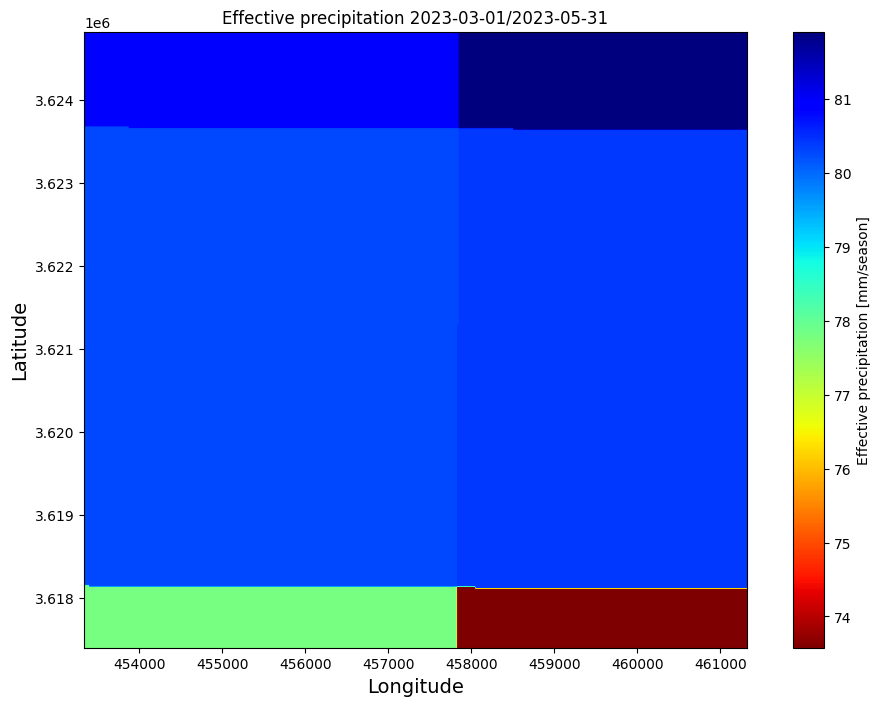

In [19]:
"""

This script processes precipitation data (PCP) and calculates effective precipitation (Peff) for each season.
It extracts geospatial info from the first PCP raster, computes monthly and seasonal PCP/Peff values, and
outputs them as raster files, along with Peff visualizations.
"""

# Collect GeoInfo from the first raster file in PCP
in_fh = input_fhsPCP[0]  # First precipitation file
ds = rio.open_rasterio(in_fh)  # Open the raster file
crs = ds.rio.crs  # Get CRS (Coordinate Reference System) of raster
NDV = ds.attrs.get('_FillValue', np.nan)  # Get NoDataValue from the raster metadata

# Iterate over each season in season_periods
for season, dates in season_periods.items():
    SOS = datetime.datetime.strptime(dates['SOS'], '%Y-%m-%d').date()  # Start date of the season (SOS)
    EOS = datetime.datetime.strptime(dates['EOS'], '%Y-%m-%d').date()  # End date of the season (EOS)

    seasonPCP, seasonPeff = None, None  # Initialize for seasonal PCP and Peff

    date_s = SOS
    while date_s < EOS:
        # Functions to get the first and last day of a month
        def first_day_of_month(date):
            return date.replace(day=1)

        def last_day_of_month(date):
            # Special case for December (month 12)
            return date.replace(day=31) if date.month == 12 else date.replace(month=date.month + 1, day=1) - datetime.timedelta(days=1)

        startdate = max(first_day_of_month(date_s), SOS)  # Start date for current month
        enddate = min(last_day_of_month(date_s), EOS)  # End date for current month

        # Calculate monthly PCP and Peff
        PCPm = SumSeason(input_fhsPCP, startdate, enddate)  # Monthly precipitation
        Peffm = np.where(PCPm <= 250, PCPm * (125 - 0.2 * PCPm) / 125, 125 + 0.1 * PCPm)  # Effective precipitation

        # Convert Peffm to a rioxarray DataArray with the correct attributes
        Peffm_da = ds.copy(data=Peffm)

        # Move to the next month
        date_s = enddate + datetime.timedelta(days=1)

        # Accumulate monthly values into seasonal totals
        seasonPCP = PCPm if seasonPCP is None else seasonPCP + PCPm
        seasonPeff = Peffm_da if seasonPeff is None else seasonPeff + Peffm_da

        # Save monthly PCP and Peff to raster format
        out_fh = os.path.join(output_folderPCPmon, f'PCPmon_{startdate}_to_{enddate}.tif')
        PCPm.rio.to_raster(out_fh, nodata=NDV, crs=crs)  # Save monthly PCP
        print(f'The mean & SD monthly PCP [mm] in {startdate}/{enddate} is {np.nanmean(PCPm).round(1)} & {np.nanstd(PCPm).round(1)}')

        out_fh = os.path.join(output_folderPCPeffmon, f'PCPeffmon_{startdate}_to_{enddate}.tif')
        Peffm_da.rio.to_raster(out_fh, nodata=NDV, crs=crs)  # Save monthly Peff
        print(f'The mean & SD monthly Peff [mm] in {startdate}/{enddate} is {np.nanmean(Peffm).round(1)} & {np.nanstd(Peffm).round(1)}')

    # Save seasonal PCP and Peff to raster format
    out_fh = os.path.join(output_folderPCP, f'PCP_{season}_{SOS}_to_{EOS}.tif')
    seasonPCP.rio.to_raster(out_fh, nodata=NDV, crs=crs)  # Save seasonal PCP
    print(f'The mean & SD seasonal PCP [mm] in {SOS}/{EOS} is {np.nanmean(seasonPCP).round(1)} & {np.nanstd(seasonPCP).round(1)}')

    out_fh = os.path.join(output_folderPCPeff, f'PCPeff_{season}_{SOS}_to_{EOS}.tif')
    seasonPeff.rio.to_raster(out_fh, nodata=NDV, crs=crs)  # Save seasonal Peff
    print(f'The mean & SD seasonal Peff [mm] in {SOS}/{EOS} is {np.nanmean(seasonPeff).round(1)} & {np.nanstd(seasonPeff).round(1)}')

    # Plot the seasonal Peff raster map with calculated spatial extent
    spatial_extent = (seasonPeff.x.min(), seasonPeff.x.max(), seasonPeff.y.min(), seasonPeff.y.max())
    plt.figure(figsize=(12, 8))
    plt.imshow(seasonPeff.squeeze(), cmap='jet_r', vmin=np.nanmin(seasonPeff), vmax=np.nanmax(seasonPeff), extent=spatial_extent)
    plt.colorbar(shrink=1, label='Effective precipitation [mm/season]')
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.title(f'Effective precipitation {SOS}/{EOS}', fontsize=12)
    plt.show()

## **8. Calculate geen and blue water consumption (Green ETa and Blue ETa)**
* Green ETa = min (Pe, ETa)
* Blue ETa  = max (0, ETa - Pe)
* where ETa is actual evapotranpiration and Pe is effective precipitaiton

In [20]:
# Define the project directory and output folder path
dir_proj = os.path.split(os.getcwd())[0]   # Get the parent directory of the current working directory
dir_data = r"/content/output/"             # Specify the directory of the folder/file
dir_data1 = "/content/content/output"  # Specify the directory of the folder/file

input_folderPeff = os.path.join(dir_proj, dir_data, "PCPeff_season")
input_fhsPeff    = sorted(glob.glob(input_folderPeff + '/*.tif'))

input_folderETas = os.path.join(dir_proj, dir_data1, "seasonal/pywapor_AETI_S")   # Define the input folder path for seasonal AETI data
input_fhsETa     = sorted(glob.glob(input_folderETas+ '/*.tif'))                 # Use glob to find all .tif files in the specified folder

input_fhsPeff, input_fhsETa

(['/content/output/PCPeff_season/PCPeff_season1_2023-03-01_to_2023-05-31.tif'],
 ['/content/content/output/seasonal/pywapor_AETI_S/pywapor_AETI_S_2022-03-01_2023-05-31.tif'])

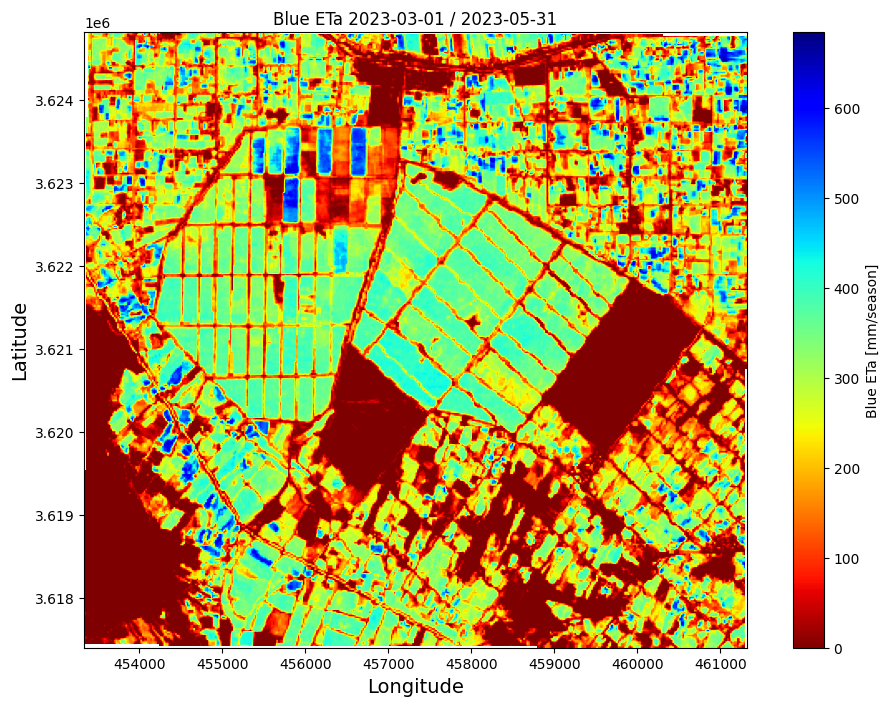

Peff min: 73.57767999999999, Peff max: 81.904336
BlueETa min: 0.0, BlueETa max: 684.7256688828124
ETa min: 8.59000015258789, ETa max: 766.6300048828125


<ipython-input-21-b0f65a728e15>:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df1.dropna(how='all')], ignore_index=True)


,Season,GreenETa_mean,GreenETa_SD,BlueETa_mean,BlueETa_SD,ETa_mean,ETa_SD
0,2023-03-01 / 2023-05-31,72.90845,16.324368,205.969426,157.159125,278.877869,167.184784


In [21]:
"""
This script processes effective precipitation (Peff) and actual evapotranspiration (ETa) raster files
to compute GreenETa (the portion of ETa met by precipitation) and BlueETa (the portion of ETa met by irrigation or other sources).
It saves the results as raster files and visualizes BlueETa as a map.
Additionally, it calculates summary statistics (mean, standard deviation) for each season and stores them in a DataFrame.
"""
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import rioxarray as rio
import xarray as xr  # Import xarray

# Set the nodata value (commonly -9999, adjust if necessary)
nodata_value = -9999.0

# Initiate an empty dataframe to store seasonal ETa statistics
df = pd.DataFrame(columns=['Season', 'GreenETa_mean', 'GreenETa_SD', 'BlueETa_mean', 'BlueETa_SD', 'ETa_mean', 'ETa_SD'])

# Loop through the pairs of Peff (effective precipitation) and ETa (actual evapotranspiration) raster files
for i, (in_fhPeff, in_fhETa) in enumerate(zip(input_fhsPeff, input_fhsETa)):
    # Open Peff and ETa raster files as DataArrays using rioxarray
    Peff = rio.open_rasterio(in_fhPeff)
    ETa = rio.open_rasterio(in_fhETa)

    # Handle nodata values (-9999 or other) by replacing them with np.nan
    Peff_data = np.where(Peff == nodata_value, np.nan, Peff)
    ETa_data = np.where(ETa == nodata_value, np.nan, ETa)

    # Calculate GreenETa (portion of ETa met by precipitation) and BlueETa (portion of ETa from other sources)
    GreenETa = np.where(Peff_data <= ETa_data, Peff_data, ETa_data)  # GreenETa = min(Peff, ETa)
    BlueETa = np.where(Peff_data > ETa_data, 0, ETa_data - Peff_data)  # BlueETa = max(0, ETa - Peff)

    # Create new DataArray for GreenETa and BlueETa using xarray
    GreenETa_da = xr.DataArray(GreenETa, coords=Peff.coords, dims=Peff.dims, attrs=Peff.attrs)
    BlueETa_da = xr.DataArray(BlueETa, coords=Peff.coords, dims=Peff.dims, attrs=Peff.attrs)

    # Extract season start (SOS) and end (EOS) dates from the season_periods dictionary
    SOS = datetime.datetime.strptime(season_periods['season1']['SOS'], '%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods['season1']['EOS'], '%Y-%m-%d').date()
    season = f"{SOS} / {EOS}"

    # Save GreenETa as a raster file
    out_fh = os.path.join(output_folderGreenBlueET, f'GreenETa_{SOS}_to_{EOS}.tif')
    GreenETa_da.rio.to_raster(out_fh, nodata=nodata_value, crs=Peff.rio.crs)

    # Save BlueETa as a raster file
    out_fh = os.path.join(output_folderGreenBlueET, f'BlueETa_{SOS}_to_{EOS}.tif')
    BlueETa_da.rio.to_raster(out_fh, nodata=nodata_value, crs=Peff.rio.crs)

    # Plot the BlueETa raster map (visualization)
    spatial_extent = (BlueETa_da.x.min(), BlueETa_da.x.max(), BlueETa_da.y.min(), BlueETa_da.y.max())  # Get spatial extent
    plt.figure(figsize=(12, 8))
    plt.imshow(BlueETa_da.squeeze(), cmap='jet_r', vmin=np.nanmin(BlueETa), vmax=np.nanmax(BlueETa), extent=spatial_extent)
    plt.colorbar(shrink=1, label='Blue ETa [mm/season]')
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.title(f'Blue ETa {SOS} / {EOS}', fontsize=12)
    plt.show()

    # Print the minimum and maximum values of Peff and BlueETa
    print(f"Peff min: {np.nanmin(Peff_data)}, Peff max: {np.nanmax(Peff_data)}")
    print(f"BlueETa min: {np.nanmin(BlueETa)}, BlueETa max: {np.nanmax(BlueETa)}")
    print(f"ETa min: {np.nanmin(ETa_data)}, ETa max: {np.nanmax(ETa_data)}")

    # Collect summary statistics (mean, standard deviation) for each variable
    data = {
        'Season': season,
        'GreenETa_mean': np.nanmean(GreenETa),
        'GreenETa_SD': np.nanstd(GreenETa),
        'BlueETa_mean': np.nanmean(BlueETa),
        'BlueETa_SD': np.nanstd(BlueETa),
        'ETa_mean': np.nanmean(ETa_data),
        'ETa_SD': np.nanstd(ETa_data)
    }

    # Convert the statistics to a DataFrame row and append to the main DataFrame
    df1 = pd.DataFrame([data])
    df = pd.concat([df, df1.dropna(how='all')], ignore_index=True)

# Display the final dataframe with seasonal statistics
df


In [22]:
# export(save) the dataframe to excel
df.to_excel(os.path.join(output_folderGreenBlueET,   'Green&BlueETa.xlsx'))
df

,Season,GreenETa_mean,GreenETa_SD,BlueETa_mean,BlueETa_SD,ETa_mean,ETa_SD
0,2023-03-01 / 2023-05-31,72.90845,16.324368,205.969426,157.159125,278.877869,167.184784


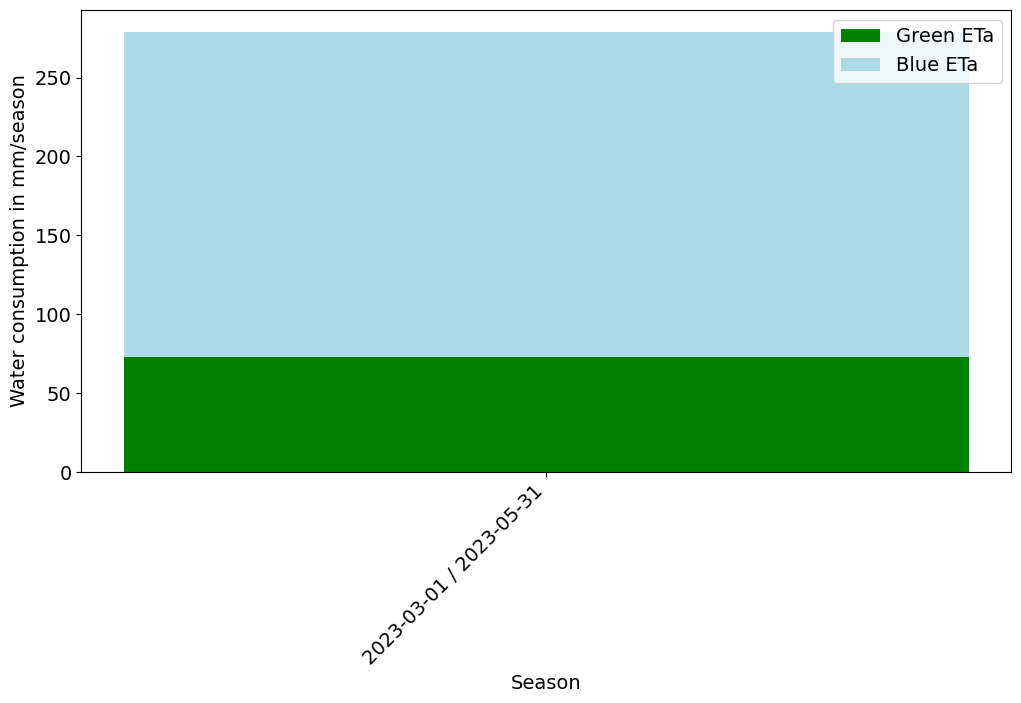

In [23]:
# Short description:
# This script plots a stacked bar chart of seasonal Green ETa and Blue ETa, representing green and blue water consumption.
# The x-axis represents seasons, and the y-axis shows water consumption in millimeters (mm) per season.

# Data set
x = df.Season[:]  # Seasons
y1 = df.GreenETa_mean[:]  # Green water consumption (ETa met by precipitation)
y2 = df.BlueETa_mean[:]  # Blue water consumption (ETa met by irrigation)

# Plot stacked bar chart
plt.subplots(figsize=(12, 6))
plt.bar(x, y1, color='g', label='Green ETa')  # Green ETa in green
plt.bar(x, y2, bottom=y1, color='lightblue', label='Blue ETa')  # Blue ETa stacked on Green ETa
plt.xlabel('Season', fontsize=14)
plt.ylabel('Water consumption in mm/season', fontsize=14)

# Rotate x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate and align x-labels at 45 degrees
plt.yticks(fontsize=14)

# Add a legend to differentiate Green and Blue ETa
plt.legend(fontsize=14)

# Display the plot
plt.show()


## **9. Zip and download seasonal data**

In [24]:
# 1) Compress the specified folders into a single zip file
!zip -r /content/CWRGreenBlueETa.zip /content/output/

# 2) Download the zipped file from Colab to your local machine
from google.colab import files
files.download(r'/content/CWRGreenBlueETa.zip')

  adding: content/output/ (stored 0%)
  adding: content/output/GreenBlueET_season/ (stored 0%)
  adding: content/output/GreenBlueET_season/Green&BlueETa.xlsx (deflated 11%)
  adding: content/output/GreenBlueET_season/GreenETa_2023-03-01_to_2023-05-31.tif (deflated 91%)
  adding: content/output/GreenBlueET_season/BlueETa_2023-03-01_to_2023-05-31.tif (deflated 64%)
  adding: content/output/PCPeff_season/ (stored 0%)
  adding: content/output/PCPeff_season/PCPeff_season1_2023-03-01_to_2023-05-31.tif (deflated 100%)
  adding: content/output/PCPeff_month/ (stored 0%)
  adding: content/output/PCPeff_month/PCPeffmon_2023-04-01_to_2023-04-30.tif (deflated 100%)
  adding: content/output/PCPeff_month/PCPeffmon_2023-05-01_to_2023-05-31.tif (deflated 100%)
  adding: content/output/PCPeff_month/PCPeffmon_2023-03-01_to_2023-03-31.tif (deflated 100%)
  adding: content/output/2L3_ETc_month/ (stored 0%)
  adding: content/output/2L3_ETc_month/ETcmon_2023-05-01_to_2023-05-31.tif (deflated 100%)
  adding: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>